In [1]:
import pickle
import numpy as np
import torch
import sys

sys.path.insert(0, '/research/iprobe-ashbau12/repos/outside/OpenGait/opengait/')
from utils.evaluation import cuda_dist

In [2]:
test_metric_file = "./all_probe_test_metrics.pkl"
with open(test_metric_file, "rb") as f:
    probe_seqs = pickle.load(f)                                 
    gallery_seqs = pickle.load(f)                               
    seq_type = pickle.load(f)
    acc = pickle.load(f)
    gallery_y = pickle.load(f)
    label = pickle.load(f)
    probe_sequence_label_mask = pickle.load(f)
    gallery_labels = pickle.load(f)
    feature = pickle.load(f)
    to_save = pickle.load(f)

In [3]:
feature.shape

(6840, 31, 256)

In [ ]:
# subject stuff
num_probe_subjects_with_gallery = len(set(label[probe_sequence_label_mask]))
num_gallery_subjects = len(set(gallery_labels))


print("Num. probe subjects with gallery: {}".format(num_probe_subjects_with_gallery))
print("Num. gallery subjects:            {}".format(num_gallery_subjects))
print(probe_seqs)

In [4]:
gallery_collapsed = []                                                      
label_collapsed = []

for l, g in to_save['gallery'].items():                                     
    label_collapsed.append(l)                                               
    gallery_collapsed.append(np.stack(g).mean(0))                           
label_collapsed = np.array(label_collapsed)                                 
gallery_collapsed = np.stack(gallery_collapsed)                             

gallery_x = gallery_collapsed                                               
gallery_y = label_collapsed   

In [5]:
all_probes = []
num_rank = 10

for (p, probe_seq) in enumerate(probe_seqs):                   
    for gallery_seq in gallery_seqs:                           
        # for (v1, probe_view) in enumerate(view_list):                     
        #     for (v2, gallery_view) in enumerate(view_list):                           
        gseq_mask = np.isin(seq_type, gallery_seq) # & np.isin(             
        #     view, [gallery_view])                                         
        '''                                                                 
        gallery_x = feature[gseq_mask, :]                                   
        gallery_y = label[gseq_mask]                                        
        '''                                                                 

        pseq_mask = np.isin(seq_type, probe_seq)                            
        # pseq_mask = np.isin(seq_type,                                     
        #                     probe_seq) & probe_sequence_label_mask        
        # & np.isin(                                                        
        #     view, [probe_view])                                           
        probe_x = feature[pseq_mask, :]                                     
        probe_y = label[pseq_mask]
        
        all_probes.append(set(probe_y))

        dist = cuda_dist(probe_x, gallery_x, 'cos')                        
        idx = dist.sort(1)[1].cpu().numpy() 
        acc[p, :, :, :] = np.round(np.sum(np.cumsum(np.reshape(probe_y, [-1, 1]) == 
                                                    gallery_y[idx[:, 0:num_rank]],
                                                    1) > 0,
                                          0) * 100 / dist.shape[0],
                                   2)

In [ ]:
probe_x.shape

In [ ]:
np.round(np.sum(np.cumsum(np.reshape(probe_y, [-1, 1]) == gallery_y[idx[:, 0:num_rank]], 1) > 0, 0)*100 / dist.shape[0], 2)

In [ ]:
(np.cumsum(np.reshape(probe_y, [-1, 1]) == gallery_y[idx[:, 0:num_rank]], 1) > 0).shape

In [6]:
probe_in_top_N = np.cumsum(np.reshape(probe_y, [-1, 1]) == gallery_y[idx[:, 0:num_rank]], 1) > 0
ranked_distances = dist.sort(1)[0][:, 0:num_rank]

mated_probes_mask = np.isin(probe_y, gallery_y)
non_mated_probes_mask = (~mated_probes_mask)
cos_distance_thresholds = np.arange(0, 1, 0.0001)


ranks = np.array([1, 5, 10]) - 1
fnirs = np.zeros((len(ranks), len(cos_distance_thresholds)))
fpirs = np.zeros((len(ranks), len(cos_distance_thresholds)))

for ii, thresh in enumerate(cos_distance_thresholds):
    for jj, rank in enumerate(ranks):
        
        true_in_col_N_with_probe_match = probe_in_top_N[mated_probes_mask, :].cumsum(axis=1) == 1
        match_N_for_each_row = true_in_col_N_with_probe_match.argmax(axis=1)
        
        fnir = np.logical_or(~probe_in_top_N[mated_probes_mask, rank],
                             (ranked_distances[mated_probes_mask, rank].cpu().numpy() > thresh)).sum()
        fpir = np.logical_or(probe_in_top_N[non_mated_probes_mask, rank],
                             (ranked_distances[non_mated_probes_mask, rank].cpu().numpy() < thresh)).sum()
    
    
        fnirs[jj, ii] = fnir
        fpirs[jj, ii] = fpir
    
fnirs = fnirs / mated_probes_mask.sum()
fpirs = fpirs / non_mated_probes_mask.sum()

In [58]:
probe_in_top_N[non_mated_probes_mask, 9]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [13]:
fnirs[0, :10]
fpirs[0, :10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [29]:
np.logical_or(~probe_in_top_N[mated_probes_mask, 9],
            (ranked_distances[mated_probes_mask, 9].cpu().numpy() > 0.25)).sum() / mated_probes_mask.sum()

0.9126984126984127

In [37]:
np.logical_or(~probe_in_top_N[mated_probes_mask, 9],
            (ranked_distances[mated_probes_mask, 9].cpu().numpy() > 0.25)).sum()

3335

In [43]:
probe_in_top_N[mated_probes_mask, :8][:10, :]

array([[False,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [55]:
true_in_col_N_with_probe_match = probe_in_top_N[mated_probes_mask, :8][:10, :].cumsum(axis=1) == 1
print(true_in_col_N_with_probe_match)
match_N_for_each_row = true_in_col_N_with_probe_match.argmax(axis=1)

[[False  True False False False False False False]
 [ True False False False False False False False]
 [False  True False False False False False False]
 [False False False False False  True False False]
 [ True False False False False False False False]
 [ True False False False False False False False]
 [ True False False False False False False False]
 [ True False False False False False False False]
 [ True False False False False False False False]
 [ True False False False False False False False]]


In [57]:
probe_in_top_N[np.where(mated_probes_mask), match_N_for_each_row]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (1,3654) (10,) 

In [ ]:
np.reshape(probe_y, [-1, 1])[:10]

In [ ]:
gallery_y[idx[:10, 0:5]]

In [ ]:
probe_in_top_N[mated_probes_mask, 0][:5]

In [7]:
import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib inline
dpi = 150

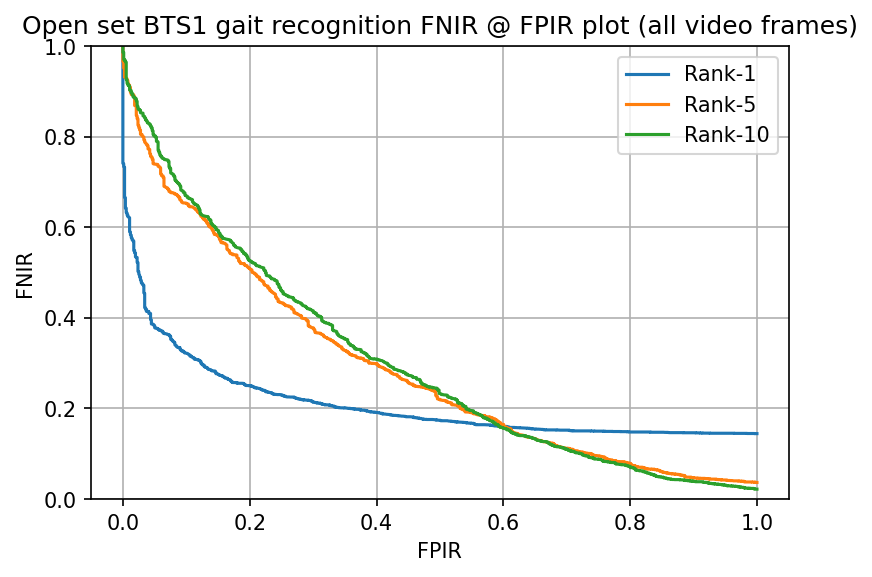

In [12]:
fig = plt.figure(facecolor='white', dpi=dpi)

for rr, rank in enumerate(ranks):
    plt.plot(fpirs[rr, :], fnirs[rr, :], label='Rank-{}'.format(rank+1))
# plt.plot(fpirs[0, :], cos_distance_thresholds, label='Cos distance threshold')
# plt.plot(cos_distance_thresholds, fnirs[0, :], label='Cos distance threshold')

    
# plt.semilogx(fpirs[0, :], fnirs[0, :], label='Rank-{}'.format(1))
# plt.semilogx(fpirs[1, :], fnirs[1, :], label='Rank-{}'.format(5))
# plt.semilogx(fpirs[2, :], fnirs[2, :], label='Rank-{}'.format(10))

plt.title('Open set BTS1 gait recognition FNIR @ FPIR plot (all video frames)')
plt.xlabel('FPIR')
plt.ylabel('FNIR')
plt.legend()
plt.grid(which='major')
plt.grid(which='minor')
plt.ylim([0, 1])
plt.show()


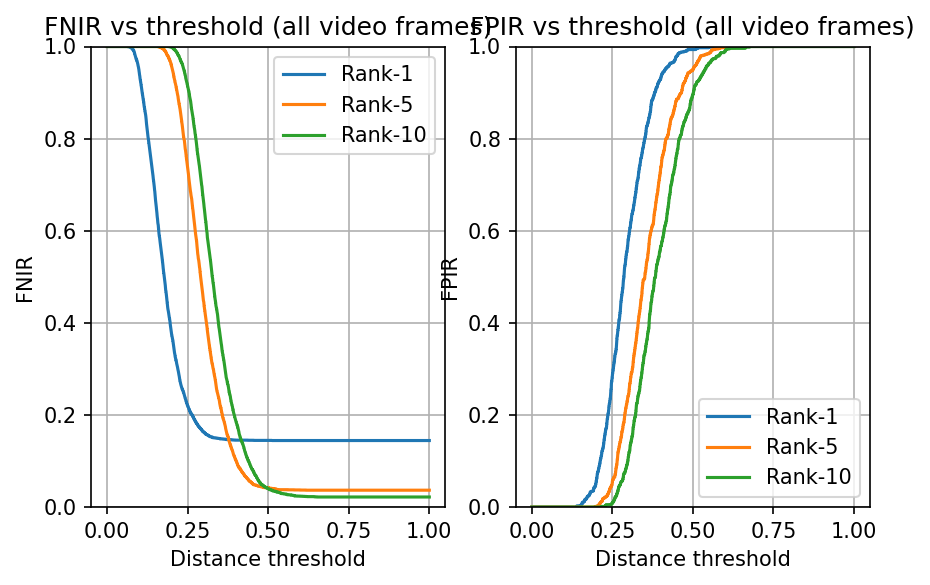

In [19]:
fig2 = plt.figure(facecolor='white', dpi=dpi)
plt.subplot(1, 2, 1)

for rr, rank in enumerate(ranks):
    plt.plot(cos_distance_thresholds, fnirs[rr, :], label='Rank-{}'.format(rank+1))
# plt.plot(fpirs[0, :], cos_distance_thresholds, label='Cos distance threshold')
# plt.plot(cos_distance_thresholds, fnirs[0, :], label='Cos distance threshold')

    
# plt.semilogx(fpirs[0, :], fnirs[0, :], label='Rank-{}'.format(1))
# plt.semilogx(fpirs[1, :], fnirs[1, :], label='Rank-{}'.format(5))
# plt.semilogx(fpirs[2, :], fnirs[2, :], label='Rank-{}'.format(10))

plt.tight_layout()
plt.title('FNIR vs threshold (all video frames)')
plt.xlabel('Distance threshold')
plt.ylabel('FNIR')
plt.legend()
plt.grid(which='major')
plt.grid(which='minor')
plt.ylim([0, 1])

plt.subplot(1, 2, 2)

for rr, rank in enumerate(ranks):
    plt.plot(cos_distance_thresholds, fpirs[rr, :], label='Rank-{}'.format(rank+1))
# plt.plot(fpirs[0, :], cos_distance_thresholds, label='Cos distance threshold')
# plt.plot(cos_distance_thresholds, fnirs[0, :], label='Cos distance threshold')

    
# plt.semilogx(fpirs[0, :], fnirs[0, :], label='Rank-{}'.format(1))
# plt.semilogx(fpirs[1, :], fnirs[1, :], label='Rank-{}'.format(5))
# plt.semilogx(fpirs[2, :], fnirs[2, :], label='Rank-{}'.format(10))

plt.tight_layout()
plt.title('FPIR vs threshold (all video frames)')
plt.xlabel('Distance threshold')
plt.ylabel('FPIR')
plt.legend()
plt.grid(which='major')
plt.grid(which='minor')
plt.ylim([0, 1])
plt.show()

